# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import string
import tensorflow as tf

!pip install nlpaug
import nlpaug.augmenter.word as naw
!pip install tqdm
from tqdm import tqdm

from bs4 import BeautifulSoup
import re
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import GlobalAveragePooling1D, Dense, TextVectorization, Input, Embedding, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# Converting Sentiment Values to binary

In [ ]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
df['sentiment'] = df['sentiment'].map({'positive': 1,'negative' :0 })
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Converting all reviews to lowercase

In [ ]:
df['review'] = df['review'].str.lower()
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. <br /><br />the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


# Removing HTML tags

In [ ]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

In [ ]:
df['review'] = df['review'].apply(remove_html_tags)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


# Remove text within brackets

In [ ]:
def remove_text_in_brackets(text):
    cleaned_text = re.sub(r'\[[^\]]*\]|\([^)]*\}|\{[^}]*\}', '', text)
    return cleaned_text

In [ ]:
df['review'] = df['review'].apply(remove_text_in_brackets)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


# Add synthetic data

In [ ]:
def augment_text_data(df, n):
    augmented_reviews = []

    aug = naw.SynonymAug(
        aug_src='wordnet',
        model_path=None,
        name='Synonym_Aug',
        aug_min=1,
        aug_max=10,
        aug_p=0.3,
        lang='eng',
        stopwords=None,
        tokenizer=None,
        reverse_tokenizer=None,
        stopwords_regex=None,
        force_reload=False,
        verbose=0
    )

    # Use tqdm to create a progress bar for the loop
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Augmenting data"):
        text = row['review']
        sentiment = row['sentiment']

        augmented_reviews.append({'review': text, 'sentiment': sentiment})

        for _ in range(n):
            augmented_text = aug.augment(text)
            augmented_reviews.append({'review': augmented_text[0], 'sentiment': sentiment})

    augmented_df = pd.DataFrame(augmented_reviews)
    return augmented_df

df = augment_text_data(df, 1)

df.head(10)

Augmenting data: 100%|██████████| 50000/50000 [16:53<00:00, 49.35it/s]


,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,one of the other reviewers has mentioned that ...,1
2,a wonderful little production. the filming tec...,1
3,a wonderful little production. the filming tec...,1
4,i thought this was a wonderful way to spend ti...,1
5,i thought this was a wonderful way to spend ti...,1
6,basically there's a family where a little boy ...,0
7,basically there ' s a family where a little bo...,0
8,"petter mattei's ""love in the time of money"" is...",1
9,"petter mattei ' s "" love in the time of money ...",1


# Remove Stop Words

In [ ]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [ ]:
df['review'] = df['review'].apply(remove_stopwords)

# IMDb Review Word Cloud generation

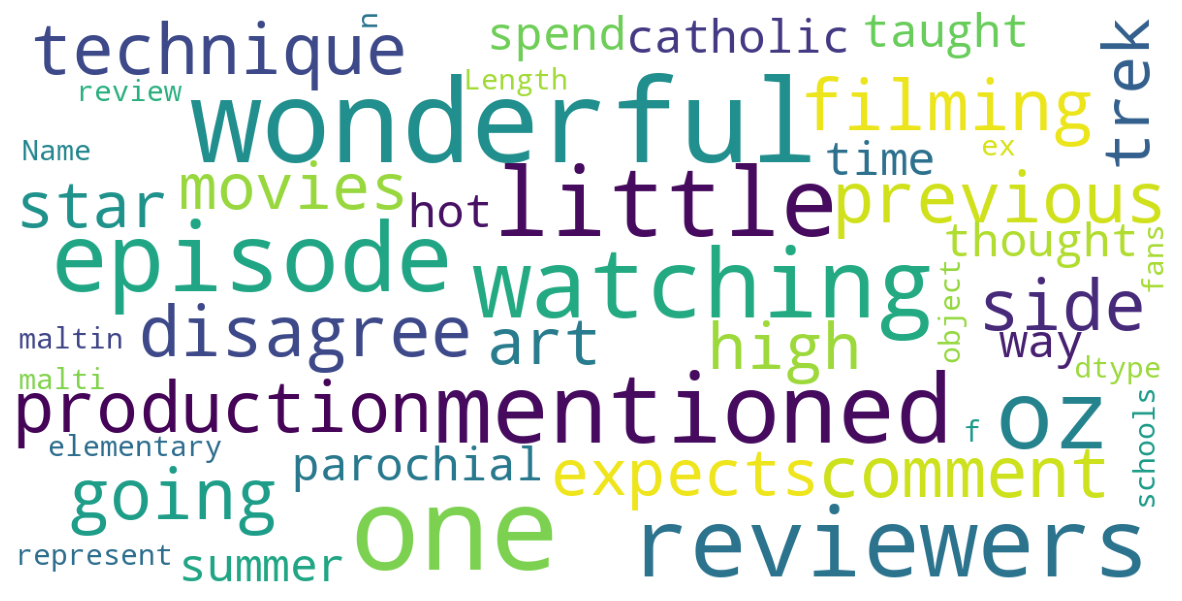

In [ ]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df["review"])

# Spliting the data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

# Creating GAP Neural Network

In [ ]:
txtVec = TextVectorization()
txtVec.adapt(df['review'])
txtVec(txtVec.get_vocabulary())

vocSize = txtVec.vocabulary_size()
print("Vocabulary Size:", vocSize)

Vocabulary Size: 231563


In [ ]:
netGAP = Sequential()

netGAP.add(Input(shape=(1,), dtype = 'string'))
netGAP.add(txtVec)
netGAP.add(Embedding(vocSize, 2))
netGAP.add(GlobalAveragePooling1D())
netGAP.add(Dense(256, activation='relu'))
netGAP.add(Dropout(0.1))
netGAP.add(Dense(128, activation='relu'))
netGAP.add(Dropout(0.1))
netGAP.add(Dense(64, activation='relu'))
netGAP.add(Dropout(0.1))
netGAP.add(BatchNormalization())
netGAP.add(Dense(32, activation='relu'))
netGAP.add(Dropout(0.1))
netGAP.add(Dense(1, activation = 'sigmoid'))

netGAP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 2)           463126    
                                                                 
 global_average_pooling1d (  (None, 2)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 256)               768       
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

# Model Training

In [ ]:
netGAP.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate=(1e-4)))

earlyStoppingCallback = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

fitGAP = netGAP.fit(X_train, y_train, batch_size=128, validation_split=0.2, epochs = 25, callbacks = [earlyStoppingCallback])

Epoch 1/2000
500/500 [==============================] - 23s 42ms/step - loss: 0.6537 - accuracy: 0.6048 - val_loss: 0.5642 - val_accuracy: 0.7536
Epoch 2/2000
500/500 [==============================] - 18s 36ms/step - loss: 0.3348 - accuracy: 0.8640 - val_loss: 0.2817 - val_accuracy: 0.8865
Epoch 3/2000
500/500 [==============================] - 16s 32ms/step - loss: 0.2464 - accuracy: 0.9056 - val_loss: 0.2503 - val_accuracy: 0.9011
Epoch 4/2000
500/500 [==============================] - 16s 32ms/step - loss: 0.2043 - accuracy: 0.9252 - val_loss: 0.2303 - val_accuracy: 0.9096
Epoch 5/2000
500/500 [==============================] - 16s 31ms/step - loss: 0.1733 - accuracy: 0.9379 - val_loss: 0.2175 - val_accuracy: 0.9176
Epoch 6/2000
500/500 [==============================] - 15s 29ms/step - loss: 0.1531 - accuracy: 0.9464 - val_loss: 0.2332 - val_accuracy: 0.9114
Epoch 7/2000
500/500 [==============================] - 13s 26ms/step - loss: 0.1282 - accuracy: 0.9570 - val_loss: 0.2762 -

# Learning Curves

In [ ]:
accFcn_gap = fitGAP.history['accuracy']
valAccFcn_gap = fitGAP.history['val_accuracy']
lossFcn_gap = fitGAP.history['loss']
valLossFcn_gap = fitGAP.history['val_loss']

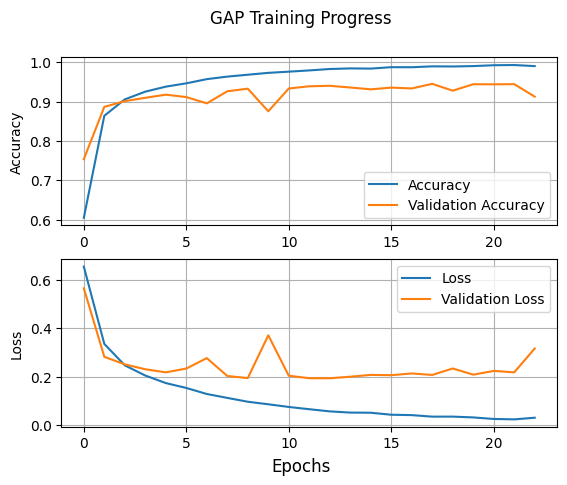

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle("GAP Training Progress")
fig.supxlabel("Epochs")

ax1.plot(accFcn_gap, label = "Accuracy")
ax1.plot(valAccFcn_gap, label = "Validation Accuracy")
ax1.set_ylabel('Accuracy')
ax1.grid("on")
ax1.legend()

ax2.plot(lossFcn_gap, label = "Loss")
ax2.plot(valLossFcn_gap, label = "Validation Loss")
ax2.set_ylabel('Loss')
ax2.grid("on")
ax2.legend()

plt.show()

# Evaluation Metrics

In [ ]:
y_pred = fitGAP.model.predict(X_test)

625/625 [==============================] - 3s 4ms/step


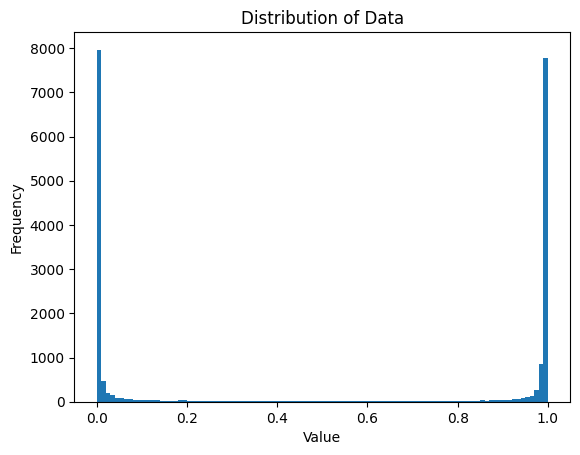

In [ ]:
plt.hist(y_pred, bins=100)  # Adjust the number of bins for more or less granularity
plt.title('Distribution of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
y_pred_binary_gap = (y_pred > 0.5).astype(int)

precision_gap = precision_score(y_test, y_pred_binary_gap)
recall_gap = recall_score(y_test, y_pred_binary_gap)
f1_gap = f1_score(y_test, y_pred_binary_gap)
accuracy_gap = accuracy_score(y_test, y_pred_binary_gap)

print(f"Precision of GAP Model: {precision_gap:.4f}")
print(f"Recall of GAP model: {recall_gap:.4f}")
print(f"F1 Score of GAP Model: {f1_gap:.4f}")
print(f"Accuracy of GAP Model: {accuracy_gap:.4f}")

Precision of GAP Model: 0.9283
Recall of GAP model: 0.9383
F1 Score of GAP Model: 0.9333
Accuracy of GAP Model: 0.9329
